# Sectioned Fourier Shell Correlation: 80nm gold beads sample

In order to characterize the new resolution estimation tool, image stacks of 80nm gold beads were acquired with our custom confocal system. By imaging single point sources it was possible to cross-check the numerical results obtained with the FSC method with direct line profile measurments from the images.

In [22]:
%matplotlib inline
from ipywidgets import interact, fixed
from scipy import ndimage

import numpy as np

import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
from supertomo.analysis.resolution.fourier_shell_correlation import DirectionalFSC
from supertomo.data.containers.image import Image
import supertomo.data.iterators.fourier_shell_iterators as iterators


def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Test Data

A sample of 80nm sub-resolution gold beads was imaged in our custom laser-scanning confocal microscope. The fluorescence filter was removed from the confocal detector (APD) to allow the recording of laser reflection signal. 

Two stacks were acquired in line-by-line fashion to enable straightforward analysis with FSC.

In [23]:
# Image
data_dir = "/Users/sami/OneDrive - Fondazione Istituto Italiano Tecnologia/Microscopy/2018_04_FSC_measures_confocal"
image_name = "2018_04_23_80nm_Gold.tif"

# Get script options
args_list = [data_dir, '--bin-delta=10', '--frc-curve-fit-degree=6', 
            '--resolution-threshold-criterion=one-bit', '--resolution-threshold-value=0.5',
            '--angle-delta=15', '--enable-hollow-iterator', '--extract-angle-delta=.1', 
             '--resolution-point-sigma=0.001']
args = options.get_frc_script_options(args_list)

# Get image
image1 = read.get_image(os.path.join(data_dir, image_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image_name), channel=1)

#image1 = Image(np.transpose(image1, (0,2,1)), image1.spacing)
#image2 = Image(np.transpose(image2, (0,2,1)), image2.spacing)

# Pre-process
#image = imops.zoom_to_isotropic_spacing(image, order=0)
image1 = imops.zero_pad_to_cube(image1)
image2 = imops.zero_pad_to_cube(image2)

interact(show_axial_slice, image1=fixed(image1), image2=fixed(image2), slice=(0, image1.shape[0]-1))

interactive(children=(IntSlider(value=62, description=u'slice', max=124), Output()), _dom_classes=('widget-interact',))

<function __main__.show_axial_slice>

## Image registration

The two image stacks were registered for robust analysis (not very important)

Setting up registration job
Starting registration
Final metric value: -0.904383525753
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 12 iterations. Current step (0.000453177) is less than minimum step (0.0005).


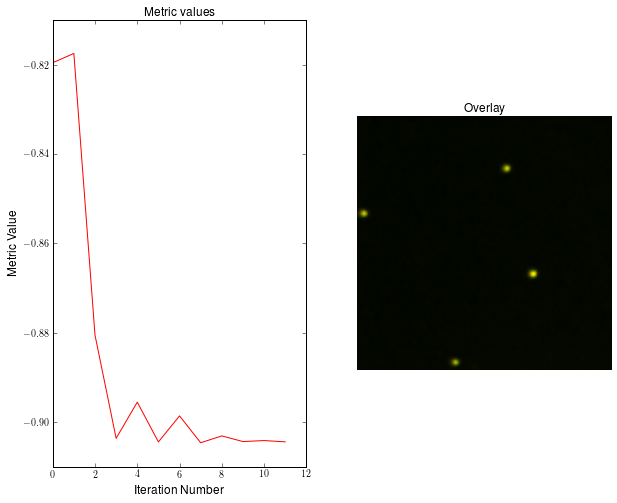

In [24]:
import SimpleITK as sitk

import supertomo.ui.supertomo_options as supertomo_options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(image1)
moving_image = itk.convert_to_itk_image(image2)


args_list_2 = ("--sampling-percentage=.01 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation " 
        "--reg-enable-observers").split()

registration_options = supertomo_options.get_debug_script_options(args_list_2)

transform = registration.itk_registration_rigid_3d(fixed_image, moving_image, registration_options)

image1 = itk.convert_from_itk_image(fixed_image)
image2 = itk.convert_from_itk_image(itk.resample_image(moving_image, transform))



## Iteration

The HollowConical iterator was used for all data analysis, as for some reason there are some strange correlations in the direction of the z-axis. Exclusion of a small central part of the section that is centered at 90° completely fixes this issue.

In [25]:
iterator = iterators.HollowConicalFourierShellIterator(image1.shape, args.d_bin, args.d_angle, args.d_extract_angle)

#iterator = iterators.RotatingFourierShellIterator(image1.shape, args.d_bin, args.d_angle)


fsc_task = DirectionalFSC(image1, image2, iterator)
data = fsc_task.execute()

## Results

For numerically correct results, **0.5 fixed threshold value should be used**, which is surprising as previous results would suggest otherwise. As discussed by Niuwenhuizen, the decision of a threshold in the end is a subjective matter, as no threshold apparently is able to give a correct result in all applicaitons. I have to whether the 0.5 point holds with more complex samples as well.

*Nieuwenhuizen, Rpj, K. A. Lidke, and Mark Bates. 2013. “Measuring Image Resolution in Optical Nanoscopy.” Nature advance on (April). https://doi.org/10.1038/nmeth.2448.
Tortarolo, Giorgio, Marco Castello, Alberto Diaspro, Sami Koho, and Giuseppe Vicidomini. 2018. “Evaluating Image Resolution in Stimulated Emission Depletion Microscopy.” Optica 5 (1): 32.*

In [26]:
import supertomo.analysis.resolution.analysis as fsc_analysis

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
result = analyzer.execute()

Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000115
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 11
         Function evaluations: 22
Optimization terminated successful

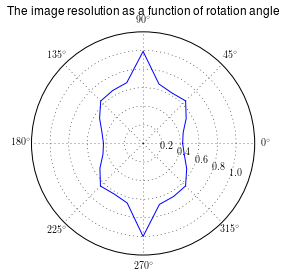

In [27]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()

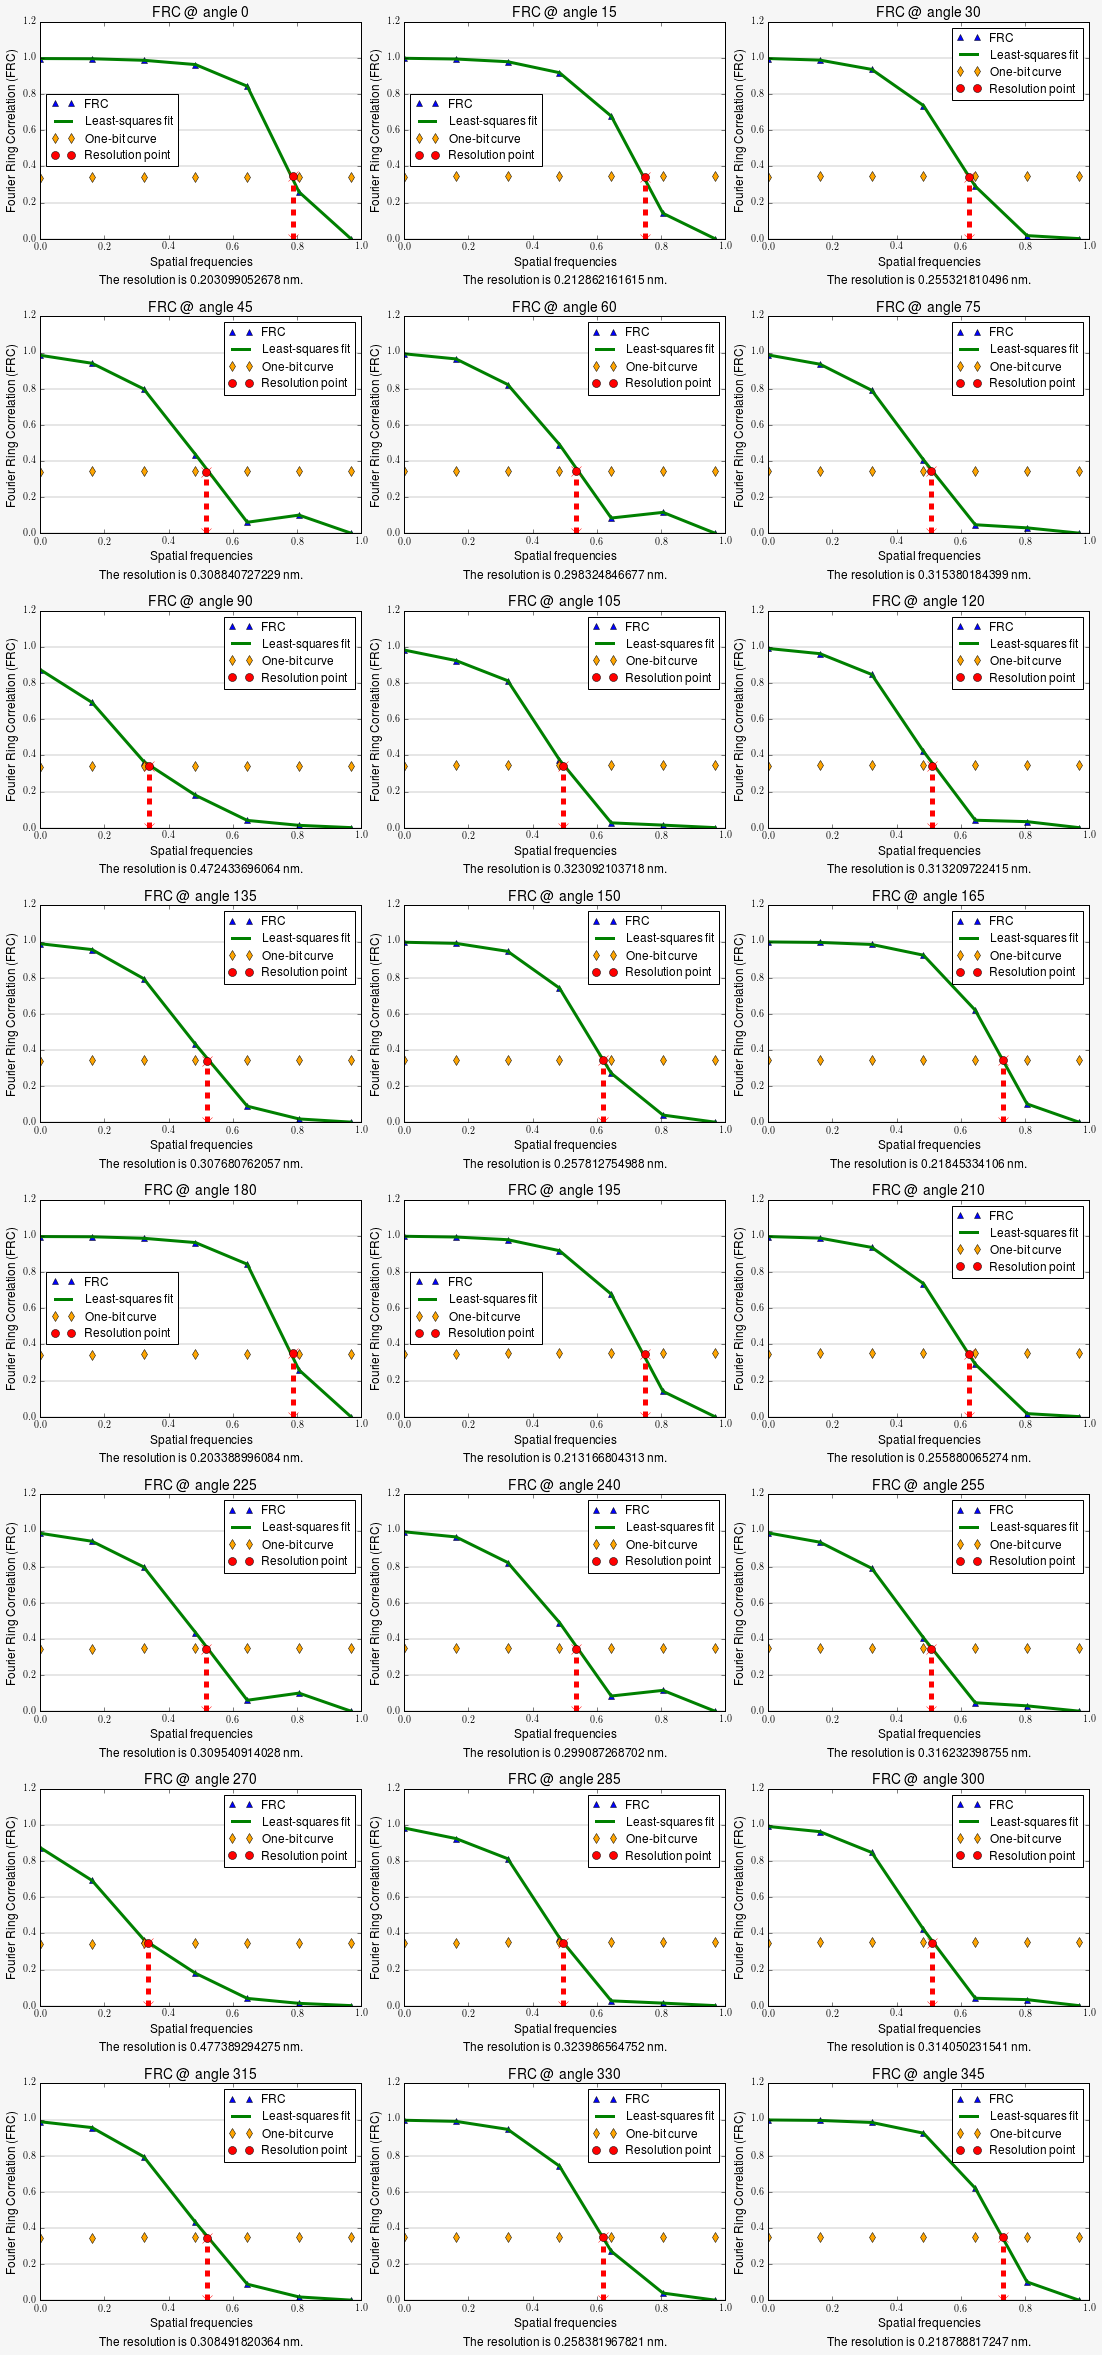

In [28]:
plotter.plot_all()